# Abordagem Inicial 

## Objetivo 

### Propor método para:
* encontrar representações comuns de diferentes modalidades sensoriais
* aumentar a quantidade de dados utilizados para redução de dimensionalidade do sinal
* melhorar a sensibilidade de análises MVPA posteriores 

### Inicialmente codificar cada instante de tempo (sem usar janelas no tempo)
### Decodificar o momento que estava na mesma e na outra modalidade a partir do estado reduzido
* Comparar com decodificação usando: (1) Sinais originais, (2) PCA geral, (3) PCA em cada ponto, (4) Auto-encoder



### Importações necessárias para execução desse notebook

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
import sys

from os import listdir
from os.path import isfile, join

from sklearn.decomposition import PCA

sys.path.append("../src/data")
from myMNE import makeMNE

### Carregando dados auditivos e visuais

In [2]:
PATH_AUD = '../data/raw/aud'
PATH_VIS = '../data/raw/vis'

PATH_INFO = '../data/raw/info_'


### Funções auxiliares para leitura do arquivo

In [3]:
def files_in_path(path):
    return [path+"/"+f for f in listdir(path) if isfile(join(path, f))]

# Getting data from MNE strutuct


def data_from_mne(files):
    return np.array([file.get_data().T for file in files])

In [4]:
# List of Files contained in the folder with path

path_file_aud = files_in_path(PATH_AUD)
path_file_vis = files_in_path(PATH_VIS)

In [5]:
# Reading files with the MNE library

files_aud = list(map(makeMNE, path_file_aud))
files_vis = list(map(makeMNE, path_file_vis))

In [6]:
# Getting data in numpy format

data_aud = data_from_mne(files_aud)
data_vis = data_from_mne(files_vis)

### Checking the shape in arrays

In [7]:
print("Data Aud with shape: {} (individual, raw, channels, trial)".format(data_aud.shape))
print("Data Vis with shape: {} (individual, raw, channels, trial)".format(data_vis.shape))

Data Aud with shape: (20, 539, 64, 240) (individual, raw, channels, trial)
Data Vis with shape: (20, 539, 64, 240) (individual, raw, channels, trial)


In [8]:
# Function to exposure separation:
# by definition in trial odd are the first exposure, and trial even the second exposure

def _exposure_1(data): 
    # [individual, raw, channels, trial]
    return data[::, ::, ::, 0:: 2]

def _exposure_2(data): 
    # [individual, raw, channels, trial]
    return data[::, ::, ::, 1:: 2]

In [9]:
## Splitting the exposures for all the individuals

aud_expo_1 = _exposure_1(data_aud)

aud_expo_2 = _exposure_2(data_aud) 

vis_expo_1 = _exposure_1(data_vis)

vis_expo_2 = _exposure_2(data_vis)

![recorte](../reports/figures/evaluate_trial.jpg)
#### Figura 01: Como recortar os trials.

In [10]:
# Auxiliary function to calculate the average in the bin


def _average(frame):
    return np.average(frame, axis=0)


# Function for splitting and compute the average in the bins
def six_bin_first(exposure):
    """Splitting array in bins for the first exposure,
    and compute the average

    Parameters
    ----------
    exposure: numpy.array (3-dimensions) [raw, channels, trial]
       Array containing data from an exposure.
    Returns
    -------
    average_frames: list of numpy.array
        average of 6 arrays with 31 points each

    """
    # Indices

    # ---------------------------------------------------------------------

    # If the zero is not at the starting point just change the value.
    zero = 39

    # End in 1500 ms
    end = 1500//4 + zero

    # 6 bins with 31 points from 250 Hz

    size = 744 // 4

    # ---------------------------------------------------------------------
    time_frame = exposure[end-size:end]

    frames = np.split(time_frame, 6)

    average_frames = np.array(list(map(_average, frames)))

    return average_frames

In [11]:
# Function for splitting and compute the average in the bins, for the second bins
def six_bin_second(exposure, indice_exposure):
    """Splitting array in bins for the first exposure,
    and compute the average

    Parameters
    ----------
    exposure: numpy.array (3-dimensions) [raw, channels, trial]
       Array containing data from an exposure.
    Returns
    -------
    average_frames: list of numpy.array
        Average of 6 arrays with 31 points each
    """
    # Indices

    # ---------------------------------------------------------------------

    # Indice moment of exposure, subtracting 124 milliseconds (31 points)
    #import pdb; pdb.set_trace()
    begin = indice_exposure - 31

    # 6 bins with 31 points from 250 Hz

    size = 744 // 4

    # ---------------------------------------------------------------------
    time_frame = exposure[begin:begin+size]

    frames = np.split(time_frame, 6)

    average_frames = np.array(list(map(_average, frames)))

    return average_frames

In [12]:
import scipy.io as sio


def indice_time_delay(name: str):

    info_path = PATH_INFO+name

    infos = list(map(sio.loadmat, files_in_path(info_path)))

    time_delay = infos[0]['report']['all_trials_delay'][0][0][0]

    return ((np.around((time_delay*250), decimals=0)))

In [13]:
indice_vis_expo = indice_time_delay('vis').astype('int')
indice_aud_expo = indice_time_delay('aud').astype('int')

### Average in the bins
----

In [14]:
aud_expo_1_frames = list(map(six_bin_first, aud_expo_1))
vis_expo_1_frames = list(map(six_bin_first, vis_expo_1))

In [15]:
aud_expo_2_frames = list(map(six_bin_second, aud_expo_2, indice_vis_expo))
vis_expo_2_frames = list(map(six_bin_second, vis_expo_2, indice_aud_expo))

----

## Com isso, iremos para o próximo passo, que consiste de aplicar o PCA para reduzir as dimensões redudantes presentes nos múltiplos canais.

Não realizamos nesse momento a separação do conjunto treino-teste, seguindo o autor original.


![aquisicao](https://raw.githubusercontent.com/bruAristimunha/Across-Modalities/master/reports/figures/mapa_rapha.jpg)
#### Figura 01: Diagrama de Reunião de Orientação. O ponto de interesse está na tabela para aplicação do PCA. Segundo os autores, eles empregaram em média 32 componentes +- 1


------------------------------------

# Studying of the number of components

In [16]:
def myPCA(data: np.array, return_data=False, n_components=0.99):

    pca_ = PCA(random_state=42, svd_solver='full', n_components=n_components)
    
    data = data.T

    data_ft = pca_.fit_transform(data)

    if(return_data):
        return data_ft
    else:
        return pca_

In [17]:
def myPCA_method(data): 
    return myPCA(data, return_data=False)
def myPCA_data(data): 
    return myPCA(data, return_data=True)

In [18]:
pcas = []

for person in aud_expo_1_frames:
    method_pca = list(map(myPCA_method,person))
    pcas.append(method_pca)
    
for person in vis_expo_1_frames:
    method_pca = list(map(myPCA_method,person))
    pcas.append(method_pca)
    
for person in aud_expo_2_frames:
    method_pca = list(map(myPCA_method,person))
    pcas.append(method_pca)
    
for person in vis_expo_2_frames:
    method_pca = list(map(myPCA_method,person))
    pcas.append(method_pca)

-------

In [19]:
import matplotlib.pylab as plt
import matplotlib

font = {'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

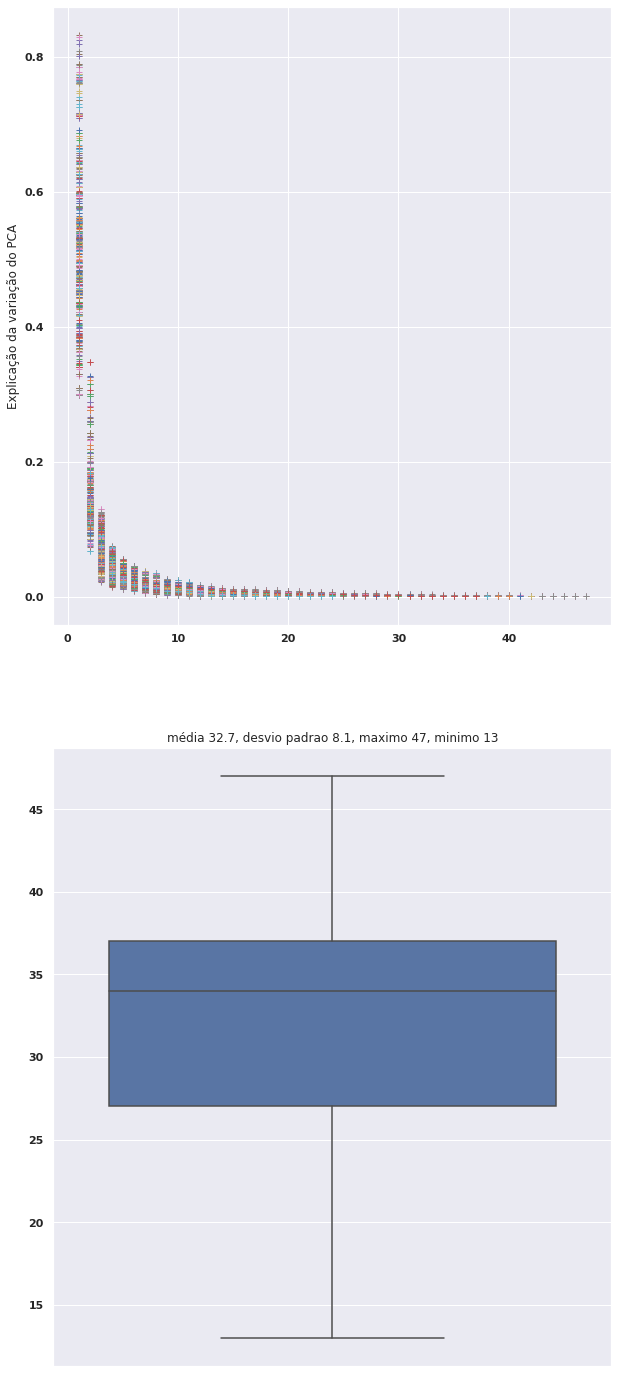

In [20]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 25))
method_pca = np.array(pcas).reshape(-1)
componentes = [pc.n_components_ for pc in method_pca]

for pc in method_pca:

    ax[0].plot(np.arange(1, pc.n_components_ + 1),
             pc.explained_variance_ratio_, '+', linewidth=2)
    ax[0].set_ylabel('Explicação da variação do PCA')

ax[1] = sns.boxplot(componentes,orient='vert',ax=ax[1])
ax[1].set_title("média {media:.5}, desvio padrao {std:.2}, maximo {maxi}, minimo {mini}".format(
                                                                        media = np.mean(componentes),
                                                                        std   = np.std(componentes), 
                                                                        maxi  = np.max(componentes),
                                                                        mini  = np.min(componentes)))
plt.show()

## Escolhemos $47$ como o número de componentes, sendo esse o número máximo de componentes necessários para explicar 99% dos dados.

In [21]:
def myPCA_47_comp(data, n_components = 47): 
    return myPCA(data, return_data=True, n_components=n_components)

In [22]:
#####################################################################    

X_aud_expo_1_frames = []

for person in aud_expo_1_frames:

    data_pca = list(map(myPCA_47_comp, person))
    X_aud_expo_1_frames.append(data_pca)
#####################################################################    

X_aud_expo_2_frames = []


for person in aud_expo_2_frames:

    data_pca = list(map(myPCA_47_comp, person))
    X_aud_expo_2_frames.append(data_pca)
    
#####################################################################

X_vis_expo_1_frames = []

for person in vis_expo_1_frames:

    data_pca = list(map(myPCA_47_comp, person))
    X_vis_expo_1_frames.append(data_pca)
    
#####################################################################    
        
X_vis_expo_2_frames = []

for person in vis_expo_2_frames:

    data_pca = list(map(myPCA_47_comp, person))
    X_vis_expo_2_frames.append(data_pca)
    
#####################################################################        
    
    

In [23]:
def to_DataFrame(X :list)-> pd.DataFrame:
    
    X_transpose = np.array(X).transpose([1, 2, 0, 3])
    
    X_preDataFrame = np.concatenate(np.concatenate(X_transpose,axis=0),axis=0)
    
    dataframe = pd.DataFrame(X_preDataFrame)
    
    dataframe = dataframe.reset_index()
    
    dataframe['person'] = (dataframe['index'] % 20)+1
    
    dataframe['trial'] = (dataframe['index'] % 120)+1
    
    dataframe['class'] = (dataframe['index'] % 6) +1
    
    dataframe = dataframe.drop('index',1)
    
    return dataframe

In [24]:
df_vis_1 = to_DataFrame(X_vis_expo_1_frames)
df_vis_2 = to_DataFrame(X_vis_expo_2_frames)

df_aud_1 = to_DataFrame(X_aud_expo_1_frames)
df_aud_2 = to_DataFrame(X_aud_expo_2_frames)

In [25]:
df_vis_1.to_csv("../data/processed/visual_exposure_1.csv",index=None)
df_vis_2.to_csv("../data/processed/visual_exposure_2.csv",index=None)

df_aud_1.to_csv("../data/processed/auditory_exposure_1.csv",index=None)
df_aud_2.to_csv("../data/processed/auditory_exposure_2.csv",index=None)


In [26]:
import pandas as pd 
df_vis_1 = pd.read_csv("../data/processed/visual_exposure_1.csv")
df_vis_2 = pd.read_csv("../data/processed/visual_exposure_2.csv")

df_aud_1 = pd.read_csv("../data/processed/auditory_exposure_1.csv")
df_aud_2 = pd.read_csv("../data/processed/auditory_exposure_2.csv")


In [27]:
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report



In [28]:
from tqdm.autonotebook import tqdm

In [29]:
from sklearn.model_selection import LeaveOneOut

def makeCatPlot(df, categoria, exposicao):
    df_result = []

    X = df.drop(['person',  'trial', 'class'],1)
    y = df['class']
    loo = LeaveOneOut()
    pbar = tqdm( total=loo.get_n_splits(X))
    
    for train_index, test_index in loo.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = GaussianNB()
        clf = clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        #import pdb; pdb.set_trace()
        df_result.append([y_pred,y_test.values,categoria,exposicao])
        pbar.update(1)
    return df_result

In [30]:
resu_vis_1 = makeCatPlot(df_vis_1,'Visual','E1')

In [31]:
resu_vis_2 = makeCatPlot(df_vis_2,'Visual','E2')

In [32]:
resu_aud_1 = makeCatPlot(df_aud_1,'Auditory','E1')

In [33]:
resu_aud_2 = makeCatPlot(df_aud_2,'Auditory','E2')

In [34]:
merge = np.concatenate([resu_vis_1,resu_vis_2, resu_aud_1, resu_aud_2])

In [35]:
plotar = pd.DataFrame(merge)

In [36]:
plotar.to_csv("resu_fig5.csv",index=None)

In [37]:
plotar[0] = plotar[0].astype(int)
plotar[1] = plotar[1].astype(int)

In [38]:
plotar.columns = ['Predicted Bin','Real Bin','Modality','Exposures']

In [39]:
#Vermelho auditory
#Azul Visual


In [40]:
exposicao1 = plotar[plotar['Exposures']=='E1']

exposicao1_aud = exposicao1[exposicao1['Modality']=='Auditory']
exposicao1_vis = exposicao1[exposicao1['Modality']=='Visual']


exposicao2 = plotar[plotar['Exposures']=='E2']

exposicao2_aud = exposicao2[exposicao2['Modality']=='Auditory']
exposicao2_vis = exposicao2[exposicao2['Modality']=='Visual']


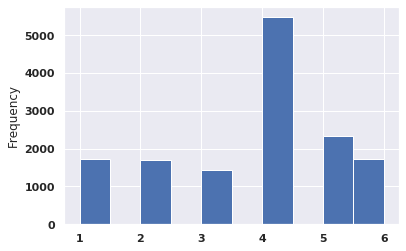

In [41]:
exposicao1_aud['Predicted Bin'].plot.hist()

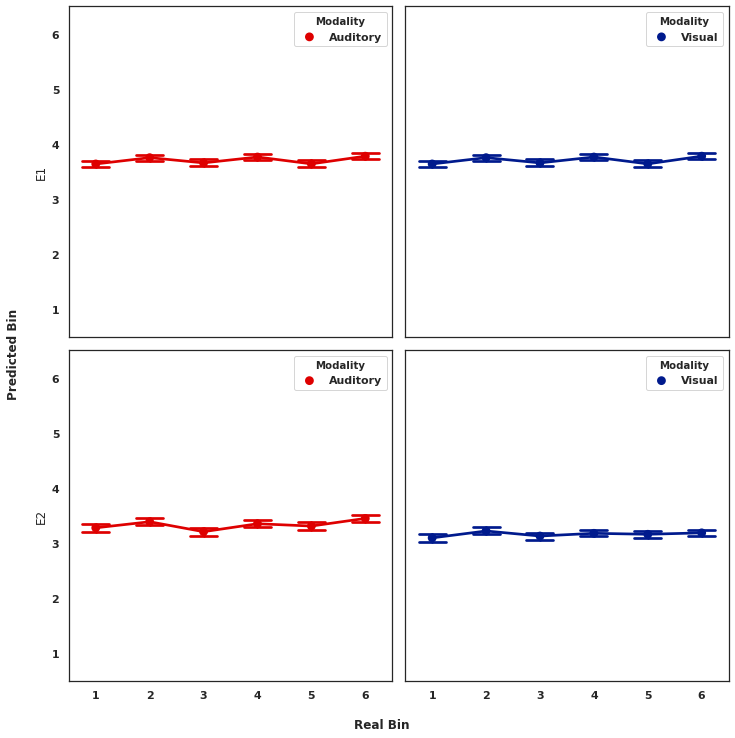

In [42]:
import seaborn as sns
sns.set(style='white')

fig, ax = plt.subplots(figsize=(10, 10), nrows=2,
                       ncols=2, sharex=True, sharey=True)

g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                capsize=.5, palette=['#de0000'], height=10, aspect=1,
                kind="point", data=exposicao1_aud, sharey=False, sharex=False, seed=42, ax=ax[0][0])

plt.close(g.fig)


ax[0][0].set(ylim=(0.5, 6.5))
ax[0][0].set(ylabel="E1", xlabel="")

g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                capsize=.5, palette=['#001a8d'], height=10, aspect=1,
                kind="point", data=exposicao1_vis, sharey=True, sharex=True, seed=42, ax=ax[0][1])
ax[0][1].set(ylabel="", xlabel='')
plt.close(g.fig)
g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                capsize=.5, palette=['#de0000'], height=10, aspect=1,
                kind="point", data=exposicao2_aud, sharey=False, sharex=False, seed=42, ax=ax[1][0])
ax[1][0].set(ylim=(0.5, 6.5))
ax[1][0].set(ylabel="E2", xlabel="")
plt.close(g.fig)
g = sns.catplot(x='Real Bin', y='Predicted Bin', hue='Modality',
                capsize=.5, palette=['#001a8d'], height=10, aspect=1,
                kind="point", data=exposicao2_vis, sharey=False, sharex=False, seed=42, ax=ax[1][1])
plt.close(g.fig)
ax[1][1].set(ylim=(0.5, 6.5))
ax[1][1].set(ylabel="", xlabel='')


fig.tight_layout()
fig.text(0.5, -0.02, 'Real Bin', ha='center')
fig.text(-0.02, 0.5, 'Predicted Bin', va='center', rotation='vertical')

plt.show()

In [43]:
print("Classificação nos Dados Visual, exposição 1")

y_test = exposicao1_vis['Predicted Bin'].values
y_pred = exposicao1_vis['Real Bin'].values


print(classification_report(y_test, y_pred))

Classificação nos Dados Visual, exposição 1
              precision    recall  f1-score   support

           1       0.13      0.18      0.15      1721
           2       0.11      0.15      0.13      1698
           3       0.12      0.20      0.15      1437
           4       0.46      0.20      0.28      5476
           5       0.18      0.18      0.18      2334
           6       0.12      0.17      0.14      1734

    accuracy                           0.19     14400
   macro avg       0.19      0.18      0.17     14400
weighted avg       0.26      0.19      0.20     14400



In [44]:
print("Classificação nos Dados Visual, exposição 2")

y_test = exposicao2_vis['Predicted Bin'].values
y_pred = exposicao2_vis['Real Bin'].values


print(classification_report(y_test, y_pred))

Classificação nos Dados Visual, exposição 2
              precision    recall  f1-score   support

           1       0.20      0.24      0.22      1995
           2       0.38      0.20      0.26      4675
           3       0.16      0.22      0.19      1808
           4       0.19      0.18      0.18      2535
           5       0.15      0.21      0.17      1712
           6       0.12      0.17      0.14      1675

    accuracy                           0.20     14400
   macro avg       0.20      0.20      0.19     14400
weighted avg       0.24      0.20      0.21     14400



In [45]:
print("Classificação nos Dados Auditivo, exposição 1")
y_test = exposicao1_aud['Predicted Bin'].values
y_pred = exposicao1_aud['Real Bin'].values

print(classification_report(y_test, y_pred))

Classificação nos Dados Auditivo, exposição 1
              precision    recall  f1-score   support

           1       0.13      0.18      0.15      1721
           2       0.11      0.15      0.13      1698
           3       0.12      0.20      0.15      1437
           4       0.46      0.20      0.28      5476
           5       0.18      0.18      0.18      2334
           6       0.12      0.17      0.14      1734

    accuracy                           0.19     14400
   macro avg       0.19      0.18      0.17     14400
weighted avg       0.26      0.19      0.20     14400



In [46]:
print("Classificação nos Dados Auditivo, exposição 2")
y_test = exposicao2_aud['Predicted Bin'].values
y_pred = exposicao2_aud['Real Bin'].values
print(classification_report(y_test, y_pred))

Classificação nos Dados Auditivo, exposição 2
              precision    recall  f1-score   support

           1       0.21      0.23      0.22      2199
           2       0.33      0.21      0.25      3787
           3       0.18      0.23      0.20      1934
           4       0.19      0.19      0.19      2356
           5       0.17      0.23      0.20      1792
           6       0.20      0.20      0.20      2332

    accuracy                           0.21     14400
   macro avg       0.21      0.21      0.21     14400
weighted avg       0.23      0.21      0.21     14400



### EEG recordings and pre-processing

EEG was recorded continuously from 64 ActiCap Electrodes (Brain Products) at 1000 Hz by a QuickAmp amplifier (Brain Products). All sites were referenced to FCz and grounded to AFz. The electrodes were positioned according to the International 10–10 system. Additional bipolar electrodes registered the electrooculogram (EOG).



EEG pre-processing was carried out using BrainVision Analyzer (Brain Products). All data were down-sampled to 250 Hz and re-referenced to the average activity across electrodes. For eye movement artefact rejection, an independent component analysis (ICA) was performed on filtered (Butterworth Zero Phase Filter between 0.05.05 Hz and 30 Hz) and segmented (−200 to 2000 ms relative to S1) data. For the ICA, epochs were baselined based on the average activity of the entire trial. Eye related components were identified by comparing individual ICA components with EOG channels and by visual inspection. The average proportion of rejected trials for each participant corresponded to 0.0613. For all further analyses, epochs were baseline corrected based on the period between −200 ms and 0 ms relative to S1 presentation.

### Similarity between different trials and modalities

To calculate the similarity across trials we used a bootstrap approach. For each participant and comparison of interest, data from all intervals that lasted at least 1.125 s were divided into two groups of trials and averaged across trials per group (Bueno et al., 2017). Then, for each time point, data from each split (two-row vectors with the averaged amplitude values of all 62 electrodes) were compared using a Pearson correlation. This procedure was repeated 5000 times for each participant and Fisher transformed coefficients were averaged across permutations for each participant and comparison of interest.

At the group level, EEG-analyses were implemented non-parametrically (Maris and Oostenveld, 2007, Wolff et al., 2015) with sign-permutation tests. For each time-point, the Fisher transformed coefficients for a random half of the participants were multiplied by. The resulting distribution was used to calculate the p-value of the null-hypothesis that the mean value was equal to 0. Cluster-based permutation tests were then used to correct for multiple comparisons across time using 5000 permutations, with a cluster-forming threshold of p (Maris and Oostenveld, 2007). The sum of the values within a cluster was used as the cluster-level statistic. The significance threshold was set at p; all tests were one-sided.

### Decoding the elapsed interval

To investigate whether information about the elapsed interval could be decoded from activity across electrodes, we used a Naive Bayes classifier to perform a multiclass classification (Grootswagers et al., 2017). For all classifications, activity from the last 125 ms of the elapsed interval (−125 ms to 0 relative to S2) was averaged for each electrode. Data for each exposure (E1 and E2) were analysed separately. Intervals were divided into six equally sized bins (125 ms each).